In [1]:
# import libraries
import math
import random
import time
#
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
#
from tensorflow.compat.v1.random import set_random_seed
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Lambda, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam

random.seed(1)
np.random.seed(1)
set_random_seed(2)

In [2]:
# parameters
test_split_pct = 60
amount_candles = 400
activations=['tanh', 'sigmoid', 'relu']
data_path = './Data'
data_file = f'{data_path}/EURUSDmicro_ H4_CandleData.txt'
ground_truth_path = f'{data_path}/Ground_truth.csv'

In [3]:
# functions
def mse(predictions, targets):
        return ((predictions - targets) ** 2).mean()

def mse_tf(predictions, targets):
        return tf.reduce_mean((predictions - targets) ** 2)

def readDataset(filename):
    text_file = open(filename, 'r')
    dataset = []   
    for line in text_file:  
        line = line.split(',')      
        dt = [ float(x) for x in line ]
        dataset.append(dt)    
    text_file.close()
    dataset = np.array(dataset)
    return dataset

def readDt2(path):
    candles_df = pd.read_csv(path)
    candles_df.drop(['Unnamed: 0'], axis=1, inplace=True)
    return candles_df

def tagData_multi_input(data, perc):
    sz  = math.ceil(data.shape[0]*perc/100)
    dat = np.zeros((data.shape[0],data.shape[1]*2))
    dat[:data.shape[0],: data.shape[1]] =data  #append column for labels
    dat[:data.shape[0]-1,data.shape[1]:] =data[1:,:]  #append column for labels
    xtrain = dat[:sz,:4]    
    ytrain = dat[:sz,4:]
    xtest  = dat[sz-1:,:4]
    ytest  = dat[sz-1:, 4:]
    xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
    xtest  = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))
    return xtrain, ytrain, xtest, ytest

def tagData_univariate(data,perc):
    sz = math.ceil(data.shape[0]*perc/100)
    dat = np.zeros((data.shape[0],data.shape[1]*2))
    dat[:data.shape[0],:data.shape[1]] =data  #append column for labels
    dat[:data.shape[0]-1,data.shape[1]:] =data[1:,:]  #append column for labels   
    candletrain = dat[:sz,:4]    
    
    yopentrain = dat[:sz,4]
    yclosetrain = dat[:sz,7]
    yhightrain = dat[:sz,5]
    ylowtrain = dat[:sz,6]
    
    candletest = dat[sz-1:,:4]
    yopentest = dat[sz-1:,4]
    yclosetest = dat[sz-1:,7]
    yhightest = dat[sz-1:,5]
    ylowtest = dat[sz-1:,6]
    
    candletrain = candletrain.reshape((candletrain.shape[0], 1, candletrain.shape[1]))
    candletest = candletest.reshape((candletest.shape[0], 1, candletest.shape[1]))
    
    return candletrain,yopentrain,yclosetrain,yhightrain,ylowtrain,candletest,yopentest,yhightest,ylowtest,yclosetest

# Load Data

In [4]:
data = readDataset(data_file)
xtrain, ytrain, xtest, ytest = tagData_multi_input(data,test_split_pct)
print('Training sample: ', xtrain.shape)
print('Testing sample: ', xtest.shape)

Training sample:  (6047, 1, 4)
Testing sample:  (4031, 1, 4)


In [5]:
xtrain2, ytrain2, xtest2, ytest2 = xtrain.reshape(len(xtrain), 4), ytrain.reshape(len(ytrain), 4), xtest.reshape(len(xtest), 4), ytest.reshape(len(ytest), 4)
print('Training sample: ', xtrain2.shape)
print('Testing sample: ', xtest2.shape)

Training sample:  (6047, 4)
Testing sample:  (4031, 4)


# Nadam, initial test

In [6]:
# https://keras.io/api/optimizers/Nadam/
"""
Nadam (short for "Nesterov-accelerated Adaptive Moment Estimation") is an optimization algorithm used in training deep neural networks. 
It combines elements of two other popular optimization algorithms: Nesterov Accelerated Gradient (NAG) and Adaptive Moment Estimation (Adam).

beta_1 and beta_2 are hyperparameters that control the exponential moving averages of the first-order moments (mean of gradients) 
and second-order moments (uncentered variance of gradients)

learning_rate is a hyperparameter that determines the step size at which the weights of a neural network are updated during the training process.

epsilon is a small positive constant added to prevent division by zero and stabilize the computation of certain statistics.

weight_decay is a regularization technique by adding a small penalty, 
usually the L2 norm of the weights (all the weights of the model), to the loss function.
"""
opt = Nadam(learning_rate=0.00001, beta_1=0.09, beta_2=0.0999, epsilon=1e-07, weight_decay=0.0004)
cand = Sequential()
cand.add(Dense(50))
cand.add(Dense(4))
cand.compile(loss=mse_tf, optimizer=opt)
start =  time.time()
cand_history = cand.fit(xtrain2, ytrain2, epochs=150, batch_size=64, validation_data=(xtest2, ytest2), verbose=1, shuffle=True)
end =  time.time()
print("Execution time: ", round(end-start,4), "seconds")
y_pred = cand.predict(xtest2)
print("MSE Open:",  mse(y_pred[:,0], ytest[:,0]))
print("MSE High:",  mse(y_pred[:,1], ytest[:,1]))
print("MSE Low:",   mse(y_pred[:,2], ytest[:,2]))
print("MSE Close:", mse(y_pred[:,3], ytest[:,3]))

Epoch 1/150


95/95 [==============================] - 1s 4ms/step - loss: 1.9451 - val_loss: 1.5531
Epoch 2/150
95/95 [==============================] - 0s 2ms/step - loss: 1.8305 - val_loss: 1.4592
Epoch 3/150
95/95 [==============================] - 0s 1ms/step - loss: 1.7197 - val_loss: 1.3683
Epoch 4/150
95/95 [==============================] - 0s 1ms/step - loss: 1.6125 - val_loss: 1.2805
Epoch 5/150
95/95 [==============================] - 0s 2ms/step - loss: 1.5086 - val_loss: 1.1957
Epoch 6/150
95/95 [==============================] - 0s 2ms/step - loss: 1.4087 - val_loss: 1.1139
Epoch 7/150
95/95 [==============================] - 0s 2ms/step - loss: 1.3120 - val_loss: 1.0351
Epoch 8/150
95/95 [==============================] - 0s 1ms/step - loss: 1.2190 - val_loss: 0.9592
Epoch 9/150
95/95 [==============================] - 0s 2ms/step - loss: 1.1294 - val_loss: 0.8863
Epoch 10/150
95/95 [==============================] - 0s 2ms/step - loss: 1.0433 - val_loss: 0.8163
Epoch 11/150
95/95 [=

# OHLC LSTM

In [7]:
class OHLC_LSTM():
    def __init__(self, activations):
        self.activations = activations
        self.history_dictionary = {}
        self.opt = tf.keras.optimizers.legacy.Nadam(learning_rate=0.00001, beta_1=0.09, beta_2=0.0999, epsilon=1e-07, decay=0.0004)
        self.predictions = {}
        
    def rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())
    
    def mse(self, predictions, targets):
        return ((predictions - targets) ** 2).mean()
    
    def train_all(self, xtrain, ytrain, epochs = 20, verbose=0):
        for i, act in enumerate(self.activations):
            start =  time.time()
            print("Started training model with activation", act, "  ", i+1,"/", len(self.activations), ".")
            cand = Sequential()
            cand.add(LSTM(200, input_shape=(xtrain.shape[1], xtrain.shape[2]), activation=act))
            cand.add(Dense(4))
            cand.compile(loss='mean_squared_error', optimizer=self.opt)
            cand_history = cand.fit(xtrain, ytrain, epochs=epochs, batch_size=72, validation_data=(xtest, ytest), verbose=verbose, shuffle=False)
            self.history_dictionary[act] = (cand_history, cand)
            print("Finished training model with activation", act, "  ", i+1,"/", len(self.activations), ".")
            end =  time.time()
            print("Execution time: ", round(end-start,4), "seconds")
    
    def plot_validation_loss(self):
        plt.figure(figsize=(6,3))
        for label, pair in self.history_dictionary.items():
            cand_history = pair[0]
            plt.plot(cand_history.history['val_loss'], label=label)
            plt.title('Validation loss')
            plt.ylabel('loss\n')
            plt.xlabel('epochs')
            plt.legend(loc='best')
        plt.show()
    
    def plot_train_loss(self):
        plt.figure(figsize=(6,3))
        for label, pair in self.history_dictionary.items():
            cand_history =pair[0]
            plt.plot(cand_history.history['loss'], label= label)
            plt.title('Training loss')
            plt.ylabel('Loss\n')
            plt.xlabel('Epochs')
            plt.legend(loc='best')
        plt.show()
        
    def evaluate(self, xtest):
        print('Predicting candles and evaluating models...')
        mapp = {"Open": 0, "High":1, "Low":2, "Close":3}
        groups = {"Open": [], "High":[], "Low": [], "Close": []}
        for label, pair in self.history_dictionary.items():
            model =pair[1]
            prediCand = model.predict(xtest)
            self.predictions[label] = prediCand
            for name, id_ in mapp.items():
                pred = prediCand[:,id_]
                act = ytest[:,id_]
                mean_sq_err = self.mse(act, pred)
                print(label, ": ", name, " MSE =>\t", mean_sq_err)
                groups[name].append(mean_sq_err)
            print(".................................................")
        return groups
            
    def plot(self, name="Open"):
        mapp = {"Open": 0, "open":0,  "High":1, "high":1 ,   "Low":2, "low":2 , "Close":3, "close":3 }
        plt.figure(figsize=(6,3))
        id_ = mapp[name]
        act = ytest[:,id_]
        label_2 = 'actual '+ name
        plt.plot(act[:len(act)-1],     label = label_2)
        for label, prediCand in self.predictions.items():
            pred = prediCand[:, id_]
            label_1 = label+ ': Predicted '+ name
            plt.plot(pred[:len(pred)-1],   label = label_1);
            plt.xlabel('Time steps')
            plt.ylabel('Price')
            plt.title('EUR/USD '+ name)
            plt.grid(True)
            plt.legend(loc = 'best')
        plt.show()

    def plot_grid(self):
        mapp = {"Open": 0, "open": 0, "High": 1, "high": 1, "Low": 2, "low": 2, "Close": 3, "close": 3 }
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
        axes = axes.flatten()
        for idx, name in enumerate(["Open", "High", "Low", "Close"]):
            ax = axes[idx]
            id_ = mapp[name]
            act = ytest[:, id_]
            label_2 = 'actual '+ name
            ax.plot(act[:len(act)-1], label=label_2)
            for label, prediCand in self.predictions.items():
                pred = prediCand[:, id_]
                label_1 = label+ ': Predicted '+ name
                ax.plot(pred[:len(pred)-1], label=label_1)
            ax.set_xlabel('Time steps')
            ax.set_ylabel('Price')
            ax.set_title('EUR/USD '+ name)
            ax.grid(True)
            ax.legend(loc='best')
        plt.tight_layout()
        plt.show()
        
    def plot_error(self, dictionary, n):
        # set width of bar
        barWidth = 0.12
        # Set position of bar on X axis
        r1 = np.arange(n)
        r2 = [x + barWidth for x in r1]
        r3 = [x + barWidth for x in r2]
        r4 = [x + barWidth for x in r3]
        plt.figure(figsize=(5, 3))
        # Make the plot
        if(n==2):
            dictionary2={}
            groups = ['tanh', 'relu']
            for k, v in dictionary.items():
                dictionary2[k] = [v[0], v[2]]
        elif(n==3):
            groups = ['tanh', 'sigmoid', 'relu']
            dictionary2 = dictionary

        plt.bar(r1, dictionary2['Open'],  color='#7f6d5f', width=barWidth, edgecolor='white', label='Open')
        plt.bar(r2, dictionary2['High'],  color='#fc9803', width=barWidth, edgecolor='white', label='High')
        plt.bar(r3, dictionary2['Low'],   color='#2d7f5e', width=barWidth, edgecolor='white', label='Low')
        plt.bar(r4, dictionary2['Close'], color='#2003fc', width=barWidth, edgecolor='white', label='Close')

        # Add xticks on the middle of the group bars
        plt.xlabel('Activation Function', fontweight='bold')
        plt.ylabel('Mean Square Error', fontweight='bold')
        plt.xticks([r + barWidth for r in range(n)], groups)
        # Create legend & Show graphic
        plt.legend(loc= "best")
        plt.show()
    
    def save_pred(self, path= ""):
        for k, v in self.predictions.items():
            file_name = path + "/OHLC_LSTM_" + k + ".csv"
            df = pd.DataFrame()
            df['Open'] = v[:,0]
            df['High'] = v[:,1]
            df['Low'] =  v[:,2]
            df['Close'] = v[:,3]
            df.to_csv(file_name)
        print(f"Finished saving file: {file_name}")
        

Started training model with activation tanh    1 / 3 .


Epoch 1/150
84/84 [==============================] - 4s 12ms/step - loss: 1.5623 - val_loss: 1.2697
Epoch 2/150
84/84 [==============================] - 0s 5ms/step - loss: 1.5233 - val_loss: 1.2372
Epoch 3/150
84/84 [==============================] - 0s 5ms/step - loss: 1.4847 - val_loss: 1.2051
Epoch 4/150
84/84 [==============================] - 0s 5ms/step - loss: 1.4464 - val_loss: 1.1733
Epoch 5/150
84/84 [==============================] - 0s 5ms/step - loss: 1.4085 - val_loss: 1.1417
Epoch 6/150
84/84 [==============================] - 0s 5ms/step - loss: 1.3707 - val_loss: 1.1103
Epoch 7/150
84/84 [==============================] - 0s 5ms/step - loss: 1.3332 - val_loss: 1.0791
Epoch 8/150
84/84 [==============================] - 0s 5ms/step - loss: 1.2959 - val_loss: 1.0479
Epoch 9/150
84/84 [==============================] - 0s 6ms/step - loss: 1.2586 - val_loss: 1.0169
Epoch 10/150
84/84 [==============================] - 1s 6ms/step - loss: 1.2214 - val_loss: 0.9859
Epoch 11

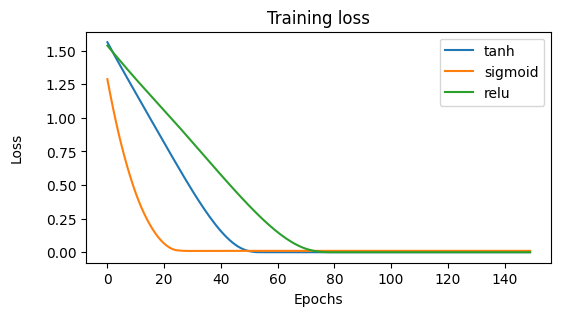

In [8]:
m = OHLC_LSTM(activations)
m.train_all(xtrain, ytrain, epochs = 150, verbose=1)
m.plot_train_loss()

Predicting candles and evaluating models...


126/126 [==============================] - 1s 1ms/step
tanh :  Open  MSE =>	 0.0003981061614100151
tanh :  High  MSE =>	 0.0004121023231011936
tanh :  Low  MSE =>	 0.00043105932369358715
tanh :  Close  MSE =>	 0.00041089493902934693
.................................................
126/126 [==============================] - 0s 1ms/step
sigmoid :  Open  MSE =>	 0.024753232209665375
sigmoid :  High  MSE =>	 0.015830967632983667
sigmoid :  Low  MSE =>	 0.017225668210146247
sigmoid :  Close  MSE =>	 0.02428123568654297
.................................................
126/126 [==============================] - 0s 1ms/step
relu :  Open  MSE =>	 0.00035726524876080704
relu :  High  MSE =>	 0.0003795630419562771
relu :  Low  MSE =>	 0.0003774879342380278
relu :  Close  MSE =>	 0.0003783738152144447
.................................................


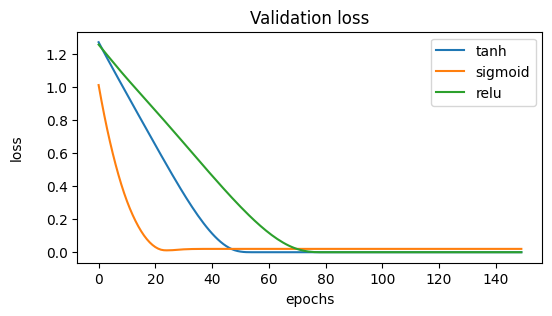

Finished saving file: ./Data/LSTM_candle_relu.csv


In [9]:
dictionary = m.evaluate(xtest)
m.plot_validation_loss()
m.save_pred(data_path)

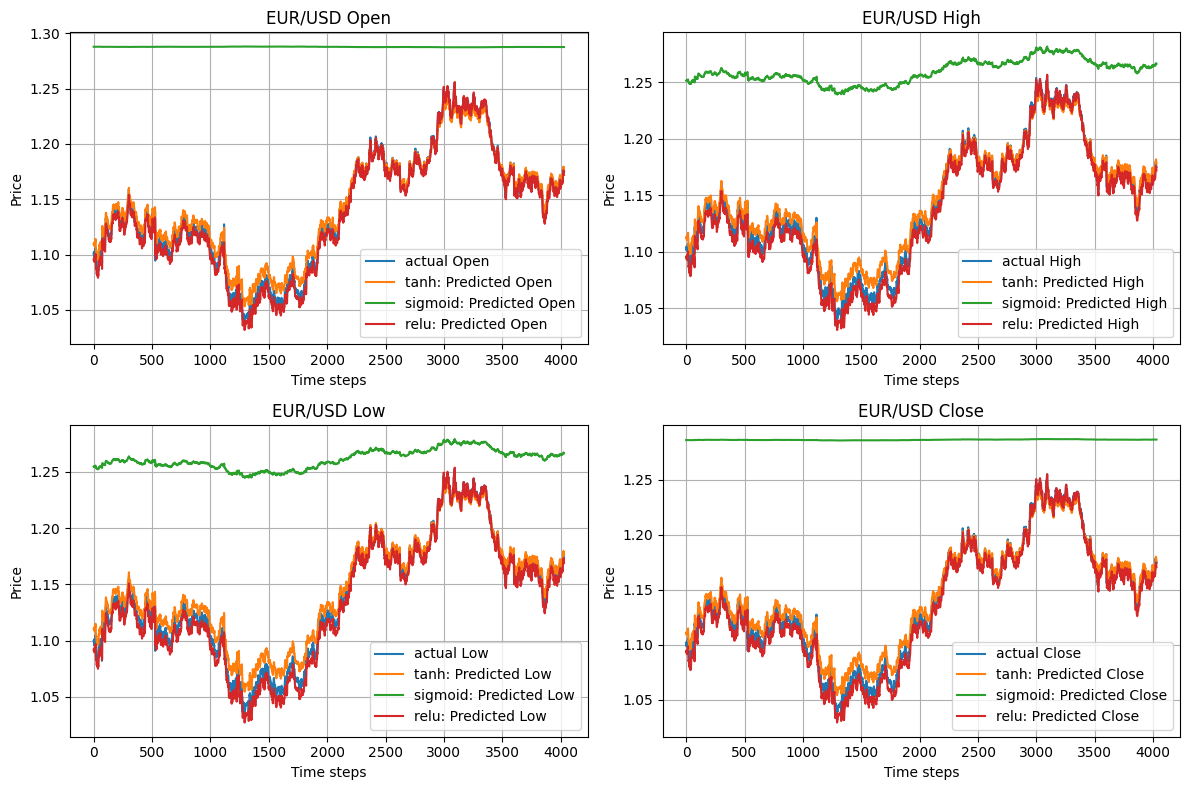

In [10]:
m.plot_grid()

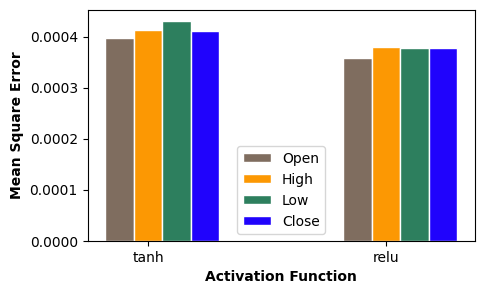

In [11]:
m.plot_error(dictionary, n=2)

# Univariate LSTM

In [12]:
candletrain, yopentrain, yclosetrain, yhightrain, ylowtrain, candletest, yopentest,\
                    yhightest, ylowtest, yclosetest = tagData_univariate(data, test_split_pct)
print('Training samples: ',candletrain.shape)
print('Testing samples: ',candletest.shape)

Training samples:  (6047, 1, 4)
Testing samples:  (4031, 1, 4)


In [13]:
class Univariate_LSTM():
    def __init__(self, candletrain, yopentrain, yclosetrain, yhightrain,
                 ylowtrain, candletest, yopentest, yhightest, ylowtest, yclosetest, activations):
        self.opt = tf.keras.optimizers.legacy.Nadam(learning_rate=0.00001, beta_1=0.09, beta_2=0.0999, epsilon=1e-07, decay=0.0004)
        self.candletrain = candletrain
        self.candletest  = candletest
        self.train_data = [yopentrain, yhightrain, ylowtrain, yclosetrain]
        self.test_data  = [yopentest,  yhightest,  ylowtest,  yclosetest]
        self.names = ["Open", "High", "Low", "Close"]
        self.history = {}
        self.activations = activations
        self.prediction = { "Open"  :{'tanh':0, 'sigmoid':0, 'relu':0},
                            "High"  :{'tanh':0, 'sigmoid':0, 'relu':0},
                            "Low"   :{'tanh':0, 'sigmoid':0, 'relu':0},
                            "Close" :{'tanh':0, 'sigmoid':0, 'relu':0}
                          }
    
    def mse(self, predictions, targets):
        return ((predictions - targets) ** 2).mean()
    
    def train_all(self, epochs=3, vb=0):
        for act in self.activations:
            local_hist = {}
            for y_train, y_test, name in zip(self.train_data, self.test_data, self.names):
                print("Training ",name, "with", act, "for", epochs, "epochs")
                m = Sequential()
                m.add(LSTM(200, input_shape=(self.candletrain.shape[1], self.candletrain.shape[2]), activation=act))
                m.add(Dense(1))
                m.compile(loss='mean_squared_error', optimizer=self.opt)
                hist = m.fit(self.candletrain, y_train, epochs=epochs, batch_size=72, 
                             validation_data=(self.candletest, y_test), verbose=vb, shuffle=False)
                local_hist[name] = (hist, m)
            self.history[act] = local_hist
            print("....................................")
            
    def plot_loss(self, mode = "val_loss"):
        price = ["Open", "High", "Low", "Close"]
        for p in price:
            plt.figure(figsize=(6,3))
            for act in self.activations:
                label = p + " " + act
                plt.plot(self.history[act][p][0].history[mode], label=label)
                plt.title(f"Training loss {p}")
                plt.ylabel('Loss')
                plt.xlabel('Epochs')
                plt.legend(loc='best')
            plt.show()
            
    def evaluate(self):
        print('Predicting candles and evaluating models...')
        groups = {"tanh": [], "sigmoid":[], "relu": []}
        for p , y_test in zip(self.names, self.test_data):
            for act in self.activations:
                model = self.history[act][p][1]
                y_pred = model.predict(self.candletest)
                self.prediction[p][act]=y_pred
                error = self.mse(y_pred, y_test)
                print(act, p,"=\t", error)
                groups[act].append(error)
            print(".................................................")
        return groups

Training  Open with tanh for 150 epochs
Epoch 1/150
84/84 [==============================] - 3s 10ms/step - loss: 1.4792 - val_loss: 1.1880
Epoch 2/150
84/84 [==============================] - 0s 5ms/step - loss: 1.4091 - val_loss: 1.1302
Epoch 3/150
84/84 [==============================] - 0s 5ms/step - loss: 1.3406 - val_loss: 1.0738
Epoch 4/150
84/84 [==============================] - 0s 6ms/step - loss: 1.2737 - val_loss: 1.0187
Epoch 5/150
84/84 [==============================] - 1s 6ms/step - loss: 1.2082 - val_loss: 0.9648
Epoch 6/150
84/84 [==============================] - 0s 5ms/step - loss: 1.1442 - val_loss: 0.9122
Epoch 7/150
84/84 [==============================] - 0s 6ms/step - loss: 1.0817 - val_loss: 0.8609
Epoch 8/150
84/84 [==============================] - 0s 5ms/step - loss: 1.0208 - val_loss: 0.8108
Epoch 9/150
84/84 [==============================] - 1s 7ms/step - loss: 0.9613 - val_loss: 0.7620
Epoch 10/150
84/84 [==============================] - 0s 6ms/step - 

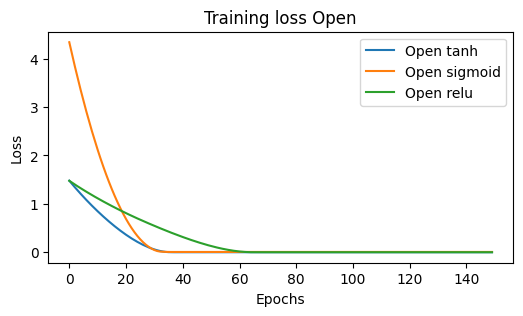

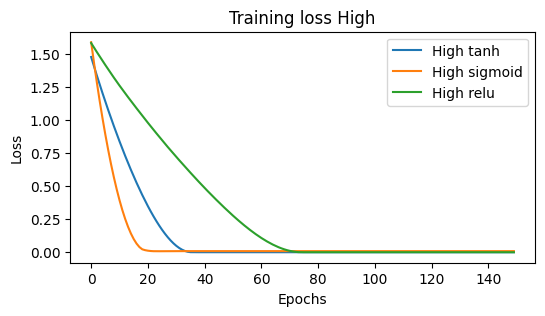

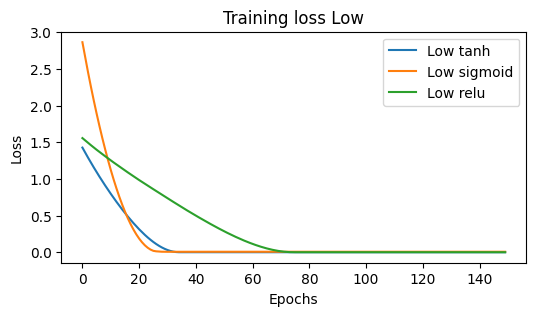

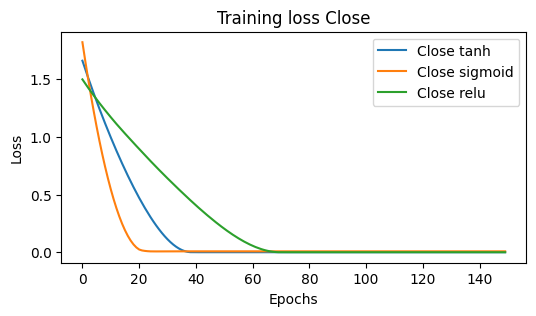

In [14]:
m = Univariate_LSTM(candletrain, yopentrain, yclosetrain, yhightrain, ylowtrain,
               candletest, yopentest, yhightest, ylowtest, yclosetest, activations)
m.train_all(epochs=150, vb=1)
m.plot_loss(mode="loss")

Predicting candles and evaluating models...
126/126 [==============================] - 1s 1ms/step
tanh Open =	 0.0053279476899050346
126/126 [==============================] - 0s 1ms/step
sigmoid Open =	 0.013000415121819483
126/126 [==============================] - 0s 1ms/step
relu Open =	 0.005954406925280873
.................................................
126/126 [==============================] - 1s 1ms/step
tanh High =	 0.005285384484315443
126/126 [==============================] - 0s 2ms/step
sigmoid High =	 0.017633140755069308
126/126 [==============================] - 0s 1ms/step
relu High =	 0.006011771133597883
.................................................
126/126 [==============================] - 1s 1ms/step
tanh Low =	 0.0052839518922282785
126/126 [==============================] - 0s 1ms/step
sigmoid Low =	 0.014149638767946778
126/126 [==============================] - 0s 1ms/step
relu Low =	 0.006023737370867756
...............................................

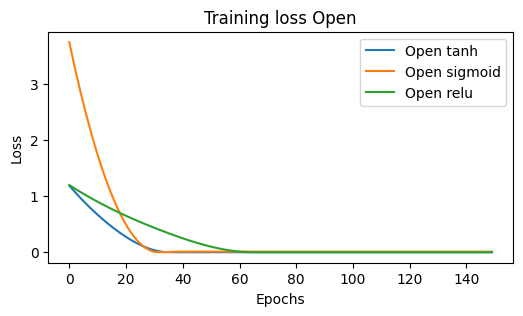

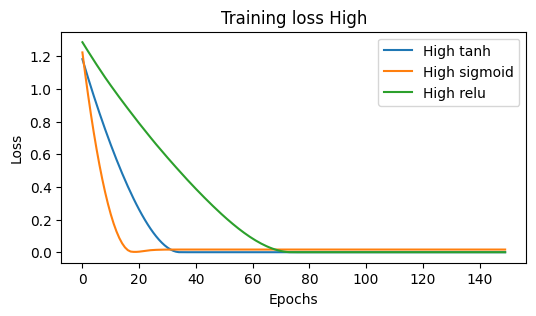

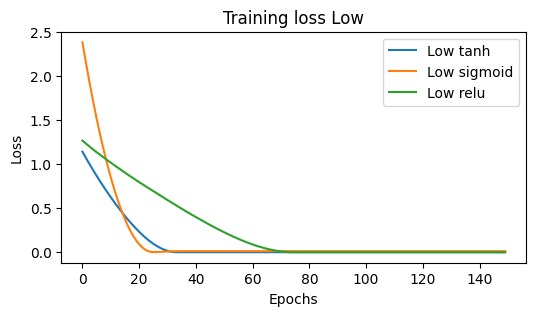

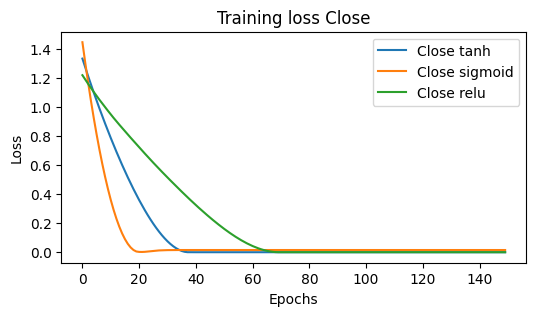

Open Value (4031, 1)
Low Value (4031, 1)
High Value (4031, 1)
Close Value (4031, 1)
(4031, 1, 4)
(4031, 1, 4)
Open Value (4031,)
Low Value (4031,)
High Value (4031,)
Close Value (4031,)


In [15]:
dictionary  = m.evaluate()
m.plot_loss(mode="val_loss")

openVal  = m.prediction['Open']['tanh']
closeVal = m.prediction['Close']['tanh']
highVal  = m.prediction['High']['tanh']
lowVal   = m.prediction['Low']['tanh']

print('Open Value',  openVal.shape)
print('Low Value',   lowVal.shape)
print('High Value',  highVal.shape)
print('Close Value', closeVal.shape)

print(candletest.shape)
candtt = candletest.reshape(candletest.shape[0], 4)
print(candletest.shape)
actualOpen = candtt[:,0]
actualHigh = candtt[:,1]
actualLow = candtt[:,2]
actualClose = candtt[:,3]

print('Open Value',  actualOpen.shape)
print('Low Value',   actualLow.shape)
print('High Value',  actualHigh.shape)
print('Close Value', actualClose.shape)

df = pd.DataFrame()
df["Open"]  = actualOpen
df["High"]  = actualHigh
df["Low"]   = actualLow
df["Close"] = actualClose
df.to_csv(ground_truth_path)

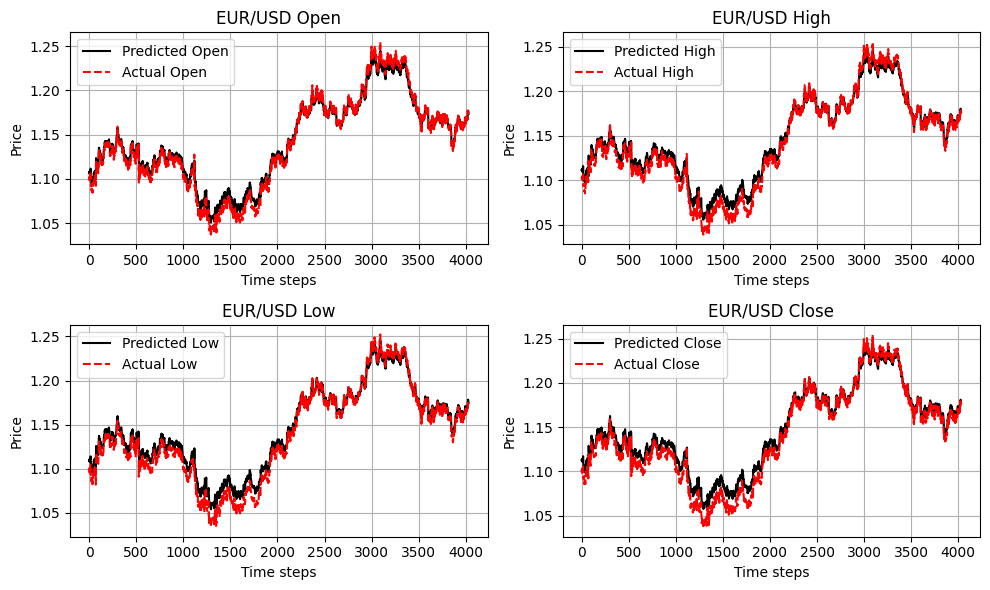

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Plot Open
axs[0, 0].plot(range(actualOpen.shape[0]-1), openVal[:len(openVal)-1], 'k-', label='Predicted Open')
axs[0, 0].plot(range(actualOpen.shape[0]-1), yopentest[:len(yopentest)-1], 'r--', label='Actual Open')
axs[0, 0].set_xlabel('Time steps')
axs[0, 0].set_ylabel('Price')
axs[0, 0].set_title('EUR/USD Open')
axs[0, 0].grid(True)
axs[0, 0].legend(loc='upper left')

# Plot High
axs[0, 1].plot(range(actualHigh.shape[0]-1), highVal[:len(highVal)-1], 'k-', label='Predicted High')
axs[0, 1].plot(range(actualHigh.shape[0]-1), yhightest[:len(yhightest)-1], 'r--', label='Actual High')
axs[0, 1].set_xlabel('Time steps')
axs[0, 1].set_ylabel('Price')
axs[0, 1].set_title('EUR/USD High')
axs[0, 1].grid(True)
axs[0, 1].legend(loc='upper left')

# Plot Low
axs[1, 0].plot(range(actualLow.shape[0]-1), lowVal[:len(lowVal)-1], 'k-', label='Predicted Low')
axs[1, 0].plot(range(actualLow.shape[0]-1), ylowtest[:len(ylowtest)-1], 'r--', label='Actual Low')
axs[1, 0].set_xlabel('Time steps')
axs[1, 0].set_ylabel('Price')
axs[1, 0].set_title('EUR/USD Low')
axs[1, 0].grid(True)
axs[1, 0].legend(loc='upper left')

# Plot Close
axs[1, 1].plot(range(actualClose.shape[0]-1), closeVal[:len(closeVal)-1], 'k-', label='Predicted Close')
axs[1, 1].plot(range(actualClose.shape[0]-1), yclosetest[:len(yclosetest)-1], 'r--', label='Actual Close')
axs[1, 1].set_xlabel('Time steps')
axs[1, 1].set_ylabel('Price')
axs[1, 1].set_title('EUR/USD Close')
axs[1, 1].grid(True)
axs[1, 1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [17]:
openV  = openVal.reshape(openVal.shape[0])
highV  = highVal.reshape(highVal.shape[0])
lowV   = lowVal.reshape(lowVal.shape[0])
closeV = closeVal.reshape(closeVal.shape[0])

fn = f'{data_path}/univariate_LSTM_tanh.csv'
df = pd.DataFrame()
df["Open"]  = openV
df["High"]  = highV
df["Low"]   = lowV
df["Close"] = closeV
df.to_csv(fn)

In [18]:
openVal_sig  = m.prediction['Open']['sigmoid'].reshape(openVal.shape[0])
highVal_sig  = m.prediction['High']['sigmoid'].reshape(openVal.shape[0])
lowVal_sig   = m.prediction['Low']['sigmoid'].reshape(openVal.shape[0])
closeVal_sig = m.prediction['Close']['sigmoid'].reshape(openVal.shape[0])

fn = f'{data_path}/univariate_LSTM_sigmoid.csv'
df = pd.DataFrame()
df["Open"]  = openVal_sig
df["High"]  = highVal_sig
df["Low"]   = lowVal_sig
df["Close"] = closeVal_sig
df.to_csv(fn)

In [19]:
openVal_relu  = m.prediction['Open']['relu'].reshape(openVal.shape[0])
highVal_relu  = m.prediction['High']['relu'].reshape(openVal.shape[0])
lowVal_relu   = m.prediction['Low']['relu'].reshape(openVal.shape[0])
closeVal_relu = m.prediction['Close']['relu'].reshape(openVal.shape[0])

fn = f'{data_path}/univariate_LSTM_relu.csv'
df = pd.DataFrame()
df["Open"]  = openVal_relu
df["High"]  = highVal_relu
df["Low"]   = lowVal_relu
df["Close"] = closeVal_relu
df.to_csv(fn)

# Forex Loss Function, simple RNN

In [20]:
class Models_FLF_SimpleRNN():
    def __init__(self, activations):
        self.activations = activations
        self.history_dictionary = {}
        self.opt = tf.keras.optimizers.legacy.Nadam(learning_rate=0.00001, beta_1=0.09, beta_2=0.0999, epsilon=1e-07, decay=0.0004)
        self.predictions = {}
        
    def rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())
    
    def mse(self, predictions, targets):
        return ((predictions - targets) ** 2).mean()
    
    @tf.function
    def FLF(self, yTrue, yPred):
        lam = 0.1
        v   = Lambda(lambda x: x*0.9)((yTrue-yPred))
        vn  = Lambda(lambda x: x*lam)(K.abs((yTrue[:,1]+yTrue[:,2])/2 - (yPred[:,1]+yPred[:,2])/2))
        vn1 = Lambda(lambda x: x*lam)(K.abs((yTrue[:,0]+yTrue[:,3])/2 - (yPred[:,0]+yPred[:,3])/2))
        vx  = K.square((v[:,0]-vn1))
        vy  = K.square((v[:,1]-vn))
        vz  = K.square((v[:,2]-vn))
        v4  = K.square((v[:,3]-vn1))
        vm  = K.concatenate([vx, vy, vz, v4])
        vmx = K.mean(vm)
        return vmx
    
    def train_all(self, xtrain, ytrain, units=100, epochs = 20, verbose=2):
        
        for i, act in enumerate(self.activations):
            start =  time.time()
            cand = Sequential()
            cand.add(SimpleRNN(units, input_shape=(xtrain.shape[1], xtrain.shape[2]) ,  activation=act))  ## CuDNNLSTM() from tf.keras.layers.
            cand.add(Dense(4))
            cand.compile(loss=self.FLF, optimizer=self.opt)
            cand_history = cand.fit(xtrain, ytrain, epochs=epochs, batch_size=72, validation_data=(xtest, ytest), verbose=verbose, shuffle=False)
            self.history_dictionary[act] = (cand_history, cand)
            print("done training model with activation", act, "  ", i+1,"/", len(self.activations), "completed.")
            end =  time.time()
            print("time of execution = ", end-start, "seconds")
    
    def plot_validation_loss(self):
        plt.figure(figsize=(8,5))
        for label, pair in self.history_dictionary.items():
            cand_history = pair[0]
            plt.plot(cand_history.history['val_loss'], label=label)
            plt.title('Validation loss')
            plt.ylabel('loss')
            plt.xlabel('epochs')
            plt.legend(loc='best')
        plt.show()
    
    def plot_train_loss(self):
        plt.figure(figsize=(8,5))
        for label, pair in self.history_dictionary.items():
            cand_history =pair[0]
            plt.plot(cand_history.history['loss'], label= label)
            plt.title('Training loss')
            plt.ylabel('loss')
            plt.xlabel('epochs')
            plt.legend(loc='best')
        plt.show()
        
    def evaluate(self, xtest, name="Open"):
        print('predicting candles and evaluating models...')
        mapp = {"Open": 0, "High":1, "Low":2, "Close":3}
        groups = {"Open": [], "High":[], "Low": [], "Close": []}
        for label, pair in self.history_dictionary.items():
            model =pair[1]
            prediCand = model.predict(xtest)
            self.predictions[label] = prediCand
            for name, id_ in mapp.items():
                pred = prediCand[:,id_]
                act = ytest[:,id_]
                mean_sq_err = self.mse(act, pred)
                print(label, ": ", name, " MSE => ", mean_sq_err)
                groups[name].append(mean_sq_err)
            print(".................................................")
        return groups
    
    def plot(self, name="Open"):
        mapp = {"Open": 0, "open":0,  "High":1, "high":1 ,   "Low":2, "low":2 , "Close":3, "close":3 }
        plt.figure(figsize=(8,5))
        id_ = mapp[name]
        act = ytest[:,id_]
        label_2 = 'actual '+ name
        plt.plot(act[:len(act)-1],     label = label_2)
        for label, prediCand in self.predictions.items():
            pred = prediCand[:, id_]
            label_1 = label+ ': Predicted '+ name
            plt.plot(pred[:len(pred)-1],   label = label_1);
            plt.xlabel('Time steps')
            plt.ylabel('Price')
            plt.title('EUR/USD '+ name)
            plt.grid(True)
            plt.legend(loc = 'best')
        plt.show()

    def plot_grid(self):
        mapp = {"Open": 0, "open": 0, "High": 1, "high": 1, "Low": 2, "low": 2, "Close": 3, "close": 3 }
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
        axes = axes.flatten()
        for idx, name in enumerate(["Open", "High", "Low", "Close"]):
            ax = axes[idx]
            id_ = mapp[name]
            act = ytest[:, id_]
            label_2 = 'actual '+ name
            ax.plot(act[:len(act)-1], label=label_2)
            for label, prediCand in self.predictions.items():
                pred = prediCand[:, id_]
                label_1 = label+ ': Predicted '+ name
                ax.plot(pred[:len(pred)-1], label=label_1)
            ax.set_xlabel('Time steps')
            ax.set_ylabel('Price')
            ax.set_title('EUR/USD '+ name)
            ax.grid(True)
            ax.legend(loc='best')
        plt.tight_layout()
        plt.show()
        
    def plot_error(self, dictionary, n):
        # set width of bar
        barWidth = 0.12
        # Set position of bar on X axis
        r1 = np.arange(n)
        r2 = [x + barWidth for x in r1]
        r3 = [x + barWidth for x in r2]
        r4 = [x + barWidth for x in r3]
        plt.figure(figsize=(5, 4))
        # Make the plot
        if(n==2):
            dictionary2={}
            groups = ['tanh', 'relu']
            for k, v in dictionary.items():
                dictionary2[k] = [v[0], v[2]]
        elif(n==3):
            groups = ['tanh', 'sigmoid', 'relu']
            dictionary2 = dictionary

        plt.bar(r1, dictionary2['Open'],  color='#7f6d5f', width=barWidth, edgecolor='white', label='Open')
        plt.bar(r2, dictionary2['High'],  color='#fc9803', width=barWidth, edgecolor='white', label='High')
        plt.bar(r3, dictionary2['Low'],   color='#2d7f5e', width=barWidth, edgecolor='white', label='Low')
        plt.bar(r4, dictionary2['Close'], color='#2003fc', width=barWidth, edgecolor='white', label='Close')

        # Add xticks on the middle of the group bars
        plt.xlabel('activation function', fontweight='bold')
        plt.ylabel('Mean Square Error', fontweight='bold')
        plt.xticks([r + barWidth for r in range(n)], groups)
        # Create legend & Show graphic
        plt.legend(loc= "best")
        plt.show()
        
    def save_pred(self, path= ""):
        for k, v in self.predictions.items():
            file_name = path + "/FLF_Simple_RNN_" + k + ".csv"
            df = pd.DataFrame()
            df['Open'] = v[:,0]
            df['High'] = v[:,1]
            df['Low'] =  v[:,2]
            df['Close'] = v[:,3]
            df.to_csv(file_name)
        print(f"Finished saving path: {file_name}")

Epoch 1/150
84/84 [==============================] - 2s 6ms/step - loss: 0.8054 - val_loss: 0.6133
Epoch 2/150
84/84 [==============================] - 0s 3ms/step - loss: 0.6965 - val_loss: 0.5256
Epoch 3/150
84/84 [==============================] - 0s 4ms/step - loss: 0.5954 - val_loss: 0.4447
Epoch 4/150
84/84 [==============================] - 0s 4ms/step - loss: 0.5022 - val_loss: 0.3705
Epoch 5/150
84/84 [==============================] - 0s 4ms/step - loss: 0.4169 - val_loss: 0.3029
Epoch 6/150
84/84 [==============================] - 0s 4ms/step - loss: 0.3394 - val_loss: 0.2422
Epoch 7/150
84/84 [==============================] - 0s 3ms/step - loss: 0.2699 - val_loss: 0.1882
Epoch 8/150
84/84 [==============================] - 0s 3ms/step - loss: 0.2083 - val_loss: 0.1409
Epoch 9/150
84/84 [==============================] - 0s 4ms/step - loss: 0.1546 - val_loss: 0.1005
Epoch 10/150
84/84 [==============================] - 0s 4ms/step - loss: 0.1090 - val_loss: 0.0670
Epoch 11/

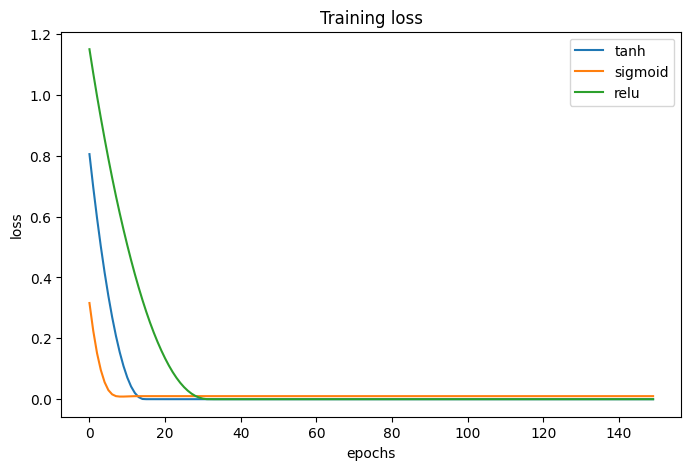

In [21]:
m = Models_FLF_SimpleRNN(activations)
m.train_all(xtrain, ytrain, units = 250, epochs = 150, verbose=1)
m.plot_train_loss()

predicting candles and evaluating models...


126/126 [==============================] - 0s 1ms/step
tanh :  Open  MSE =>  0.00041291408400948243
tanh :  High  MSE =>  0.00039098768903918164
tanh :  Low  MSE =>  0.0003941653038956984
tanh :  Close  MSE =>  0.0005053585011578375
.................................................
126/126 [==============================] - 0s 1ms/step
sigmoid :  Open  MSE =>  0.017559183278630788
sigmoid :  High  MSE =>  0.02020354928008862
sigmoid :  Low  MSE =>  0.02063193601287579
sigmoid :  Close  MSE =>  0.017593178718992915
.................................................
126/126 [==============================] - 0s 1ms/step
relu :  Open  MSE =>  0.000368957354624695
relu :  High  MSE =>  0.0003752963161259433
relu :  Low  MSE =>  0.0004874633696129667
relu :  Close  MSE =>  0.00036595429176521744
.................................................
Finished saving path: ./Data/FLF_Simple_RNN_relu.csv


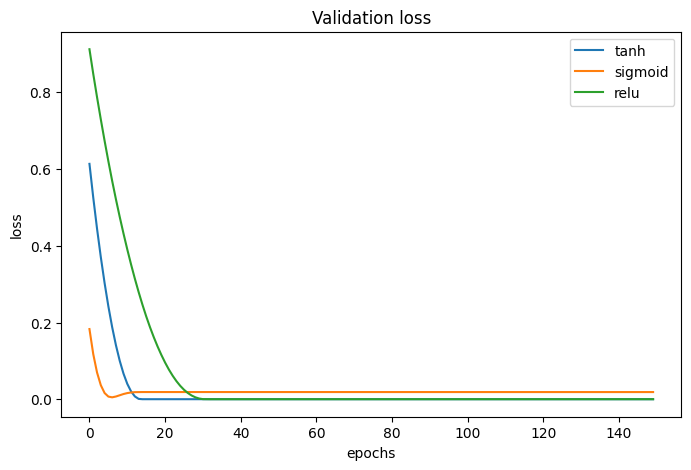

In [22]:
dictionary  = m.evaluate(xtest)
m.save_pred(data_path)
m.plot_validation_loss()

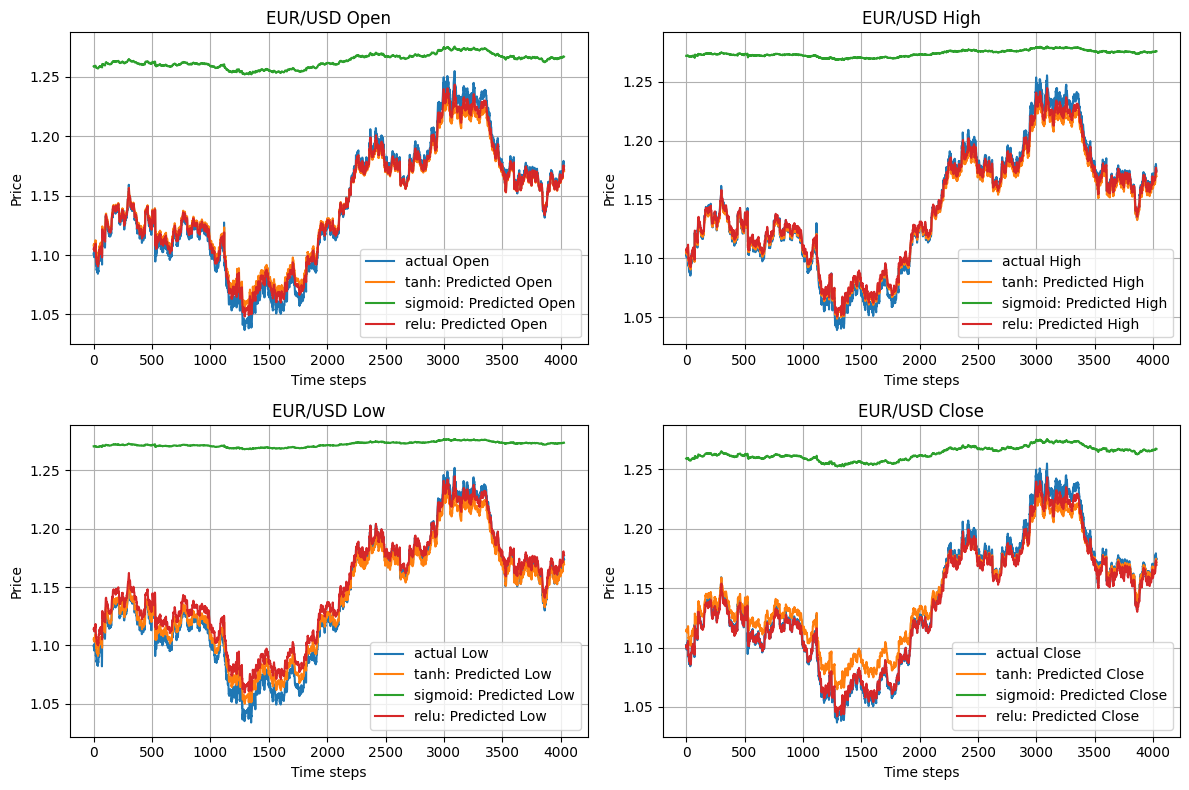

In [23]:
m.plot_grid()

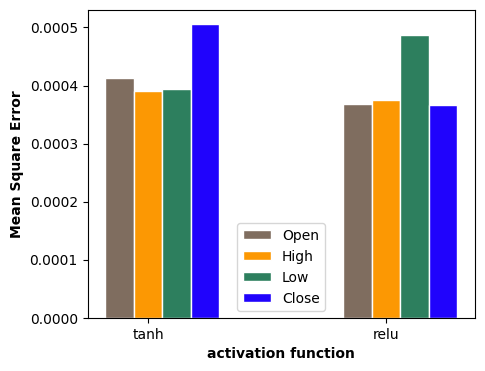

In [24]:
m.plot_error(dictionary, n=2)

# Forex Loss Function

In [25]:
class Models_FLF():
    def __init__(self, activations):
        self.activations = activations
        self.history_dictionary = {}
        self.opt = tf.keras.optimizers.legacy.Nadam(learning_rate=0.00001, beta_1=0.09, beta_2=0.0999, epsilon=1e-07, decay=0.0004)
        self.predictions = {}
        
    def rmse(self, predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())
    
    def mse(self, predictions, targets):
        return ((predictions - targets) ** 2).mean()
    
    @tf.function
    def FLF(self, yTrue, yPred):
        lam = 0.1
        v   = Lambda(lambda x: x*0.9)((yTrue-yPred))
        vn  = Lambda(lambda x: x*lam)(K.abs((yTrue[:,1]+yTrue[:,2])/2 - (yPred[:,1]+yPred[:,2])/2))
        vn1 = Lambda(lambda x: x*lam)(K.abs((yTrue[:,0]+yTrue[:,3])/2 - (yPred[:,0]+yPred[:,3])/2))
        vx  = K.square((v[:,0]-vn1))
        vy  = K.square((v[:,1]-vn))
        vz  = K.square((v[:,2]-vn))
        v4  = K.square((v[:,3]-vn1))
        vm  = K.concatenate([vx, vy, vz, v4])
        vmx = K.mean(vm)
        return vmx
    
    def train_all(self, xtrain, ytrain, units=100, epochs = 20, verbose=2):
        
        for i, act in enumerate(self.activations):
            start =  time.time()
            cand = Sequential()
            ## CuDNNLSTM() from tf.keras.layers.
            cand.add(LSTM(units, input_shape=(xtrain.shape[1], xtrain.shape[2]) ,  activation=act))  ## CuDNNLSTM() from tf.keras.layers.
            cand.add(Dense(4))
            ############################
            cand.compile(loss=self.FLF, optimizer=self.opt)#'Nadam'
            cand_history = cand.fit(xtrain, ytrain, epochs=epochs, batch_size=72, validation_data=(xtest, ytest), verbose=verbose, shuffle=False)
            self.history_dictionary[act] = (cand_history, cand)
            print("done training model with activation", act, "  ", i+1,"/", len(self.activations), "completed.")
            end =  time.time()
            print("time of execution = ", end-start, "seconds")
    
    def plot_validation_loss(self):
        plt.figure(figsize=(8,5))
        for label, pair in self.history_dictionary.items():
            cand_history = pair[0]
            plt.plot(cand_history.history['val_loss'], label=label)
            plt.title('Candle validation loss')
            plt.ylabel('loss')
            plt.xlabel('epochs')
            plt.legend(loc='best')
        plt.show()
    
    def plot_train_loss(self):
        plt.figure(figsize=(8,5))
        for label, pair in self.history_dictionary.items():
            cand_history =pair[0]
            plt.plot(cand_history.history['loss'], label= label)
            plt.title('Candle training loss')
            plt.ylabel('loss')
            plt.xlabel('epochs')
            plt.legend(loc='best')
        plt.show()
        
    def evaluate(self, xtest, name="Open"):
        print('predicting candles and evaluating models...')
        mapp = {"Open": 0, "High":1, "Low":2, "Close":3}
        groups = {"Open": [], "High":[], "Low": [], "Close": []}
        for label, pair in self.history_dictionary.items():
            model =pair[1]
            prediCand = model.predict(xtest)
            self.predictions[label] = prediCand
            for name, id_ in mapp.items():
                pred = prediCand[:,id_]
                act = ytest[:,id_]
                mean_sq_err = self.mse(act, pred)
                print(label, ": ", name, " MSE => ", mean_sq_err)
                groups[name].append(mean_sq_err)
            print(".................................................")
        return groups
    
    def plot(self, name="Open"):
        mapp = {"Open": 0, "open":0,  "High":1, "high":1 ,   "Low":2, "low":2 , "Close":3, "close":3 }
        plt.figure(figsize=(8,5))
        id_ = mapp[name]
        act = ytest[:,id_]
        label_2 = 'actual '+ name + ' price'
        plt.plot(act[:len(act)-1],     label = label_2)
        for label, prediCand in self.predictions.items():
            pred = prediCand[:, id_]
            label_1 = label+ ': Predicted '+ name + ' price'
            plt.plot(pred[:len(pred)-1],   label = label_1);
            plt.xlabel('Time steps')
            plt.ylabel('Price')
            plt.title('EUR/USD '+ name +' price')
            plt.grid(True)
            plt.legend(loc = 'best')
        plt.show()

    def plot_grid(self):
        mapp = {"Open": 0, "open": 0, "High": 1, "high": 1, "Low": 2, "low": 2, "Close": 3, "close": 3 }
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
        axes = axes.flatten()
        for idx, name in enumerate(["Open", "High", "Low", "Close"]):
            ax = axes[idx]
            id_ = mapp[name]
            act = ytest[:, id_]
            label_2 = 'actual '+ name
            ax.plot(act[:len(act)-1], label=label_2)
            for label, prediCand in self.predictions.items():
                pred = prediCand[:, id_]
                label_1 = label+ ': Predicted '+ name
                ax.plot(pred[:len(pred)-1], label=label_1)
            ax.set_xlabel('Time steps')
            ax.set_ylabel('Price')
            ax.set_title('EUR/USD '+ name)
            ax.grid(True)
            ax.legend(loc='best')
        plt.tight_layout()
        plt.show()
        
    def plot_error(self, dictionary, n):
        # set width of bar
        barWidth = 0.12
        # Set position of bar on X axis
        r1 = np.arange(n)
        r2 = [x + barWidth for x in r1]
        r3 = [x + barWidth for x in r2]
        r4 = [x + barWidth for x in r3]
        plt.figure(figsize=(5, 4))
        # Make the plot
        if(n==2):
            dictionary2={}
            groups = ['tanh', 'relu']
            for k, v in dictionary.items():
                dictionary2[k] = [v[0], v[2]]
        elif(n==3):
            groups = ['tanh', 'sigmoid', 'relu']
            dictionary2 = dictionary

        plt.bar(r1, dictionary2['Open'],  color='#7f6d5f', width=barWidth, edgecolor='white', label='Open')
        plt.bar(r2, dictionary2['High'],  color='#fc9803', width=barWidth, edgecolor='white', label='High')
        plt.bar(r3, dictionary2['Low'],   color='#2d7f5e', width=barWidth, edgecolor='white', label='Low')
        plt.bar(r4, dictionary2['Close'], color='#2003fc', width=barWidth, edgecolor='white', label='Close')

        # Add xticks on the middle of the group bars
        plt.xlabel('Activation Function', fontweight='bold')
        plt.ylabel('Mean Square Error', fontweight='bold')
        plt.xticks([r + barWidth for r in range(n)], groups)
        # Create legend & Show graphic
        plt.legend(loc= "best")
        plt.show()

    def save_pred(self, path= ""):
        for k, v in self.predictions.items():
            file_name = path + "/FLF_" + k + ".csv"
            df = pd.DataFrame()
            df['Open'] = v[:,0]
            df['High'] = v[:,1]
            df['Low'] =  v[:,2]
            df['Close'] = v[:,3]
            df.to_csv(file_name)
        print(f"Finished saving path: {file_name}")

Epoch 1/150
84/84 [==============================] - 3s 13ms/step - loss: 0.9481 - val_loss: 0.7694
Epoch 2/150
84/84 [==============================] - 1s 6ms/step - loss: 0.9221 - val_loss: 0.7477
Epoch 3/150
84/84 [==============================] - 1s 7ms/step - loss: 0.8962 - val_loss: 0.7262
Epoch 4/150
84/84 [==============================] - 1s 6ms/step - loss: 0.8705 - val_loss: 0.7048
Epoch 5/150
84/84 [==============================] - 1s 6ms/step - loss: 0.8448 - val_loss: 0.6834
Epoch 6/150
84/84 [==============================] - 1s 7ms/step - loss: 0.8192 - val_loss: 0.6620
Epoch 7/150
84/84 [==============================] - 1s 6ms/step - loss: 0.7935 - val_loss: 0.6406
Epoch 8/150
84/84 [==============================] - 1s 7ms/step - loss: 0.7679 - val_loss: 0.6192
Epoch 9/150
84/84 [==============================] - 1s 6ms/step - loss: 0.7422 - val_loss: 0.5978
Epoch 10/150
84/84 [==============================] - 1s 6ms/step - loss: 0.7165 - val_loss: 0.5764
Epoch 11

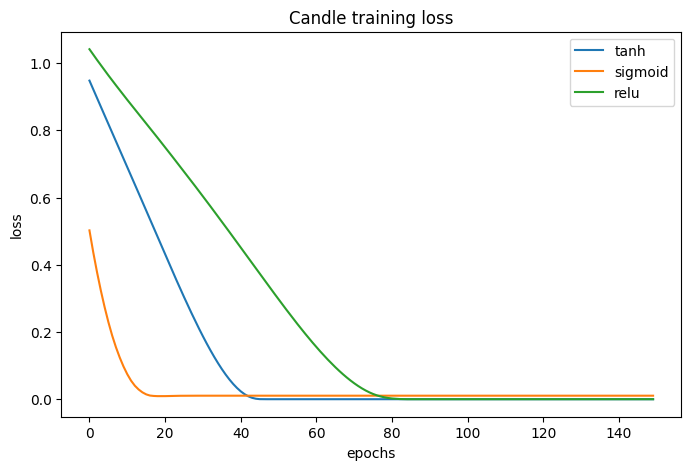

In [26]:
m = Models_FLF(activations)
m.train_all(xtrain, ytrain, units = 250, epochs = 150, verbose=1)
m.plot_train_loss()

predicting candles and evaluating models...


126/126 [==============================] - 1s 2ms/step
tanh :  Open  MSE =>  0.0003708088250431138
tanh :  High  MSE =>  0.00037164411839122756
tanh :  Low  MSE =>  0.0003687317799485974
tanh :  Close  MSE =>  0.0003692378073834082
.................................................
126/126 [==============================] - 0s 1ms/step
sigmoid :  Open  MSE =>  0.019997444452403687
sigmoid :  High  MSE =>  0.01710413055429729
sigmoid :  Low  MSE =>  0.023995933351848093
sigmoid :  Close  MSE =>  0.025043884611122086
.................................................
126/126 [==============================] - 0s 1ms/step
relu :  Open  MSE =>  0.00035247788645797275
relu :  High  MSE =>  0.0003521057014288957
relu :  Low  MSE =>  0.0003504575245650766
relu :  Close  MSE =>  0.00036498922706132045
.................................................
Finished saving path: ./Data/FLF_relu.csv


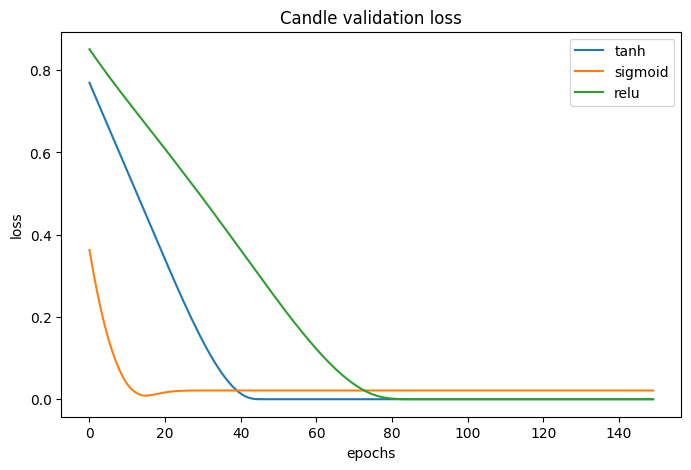

In [27]:
dictionary  = m.evaluate(xtest)
m.save_pred(data_path)
m.plot_validation_loss()

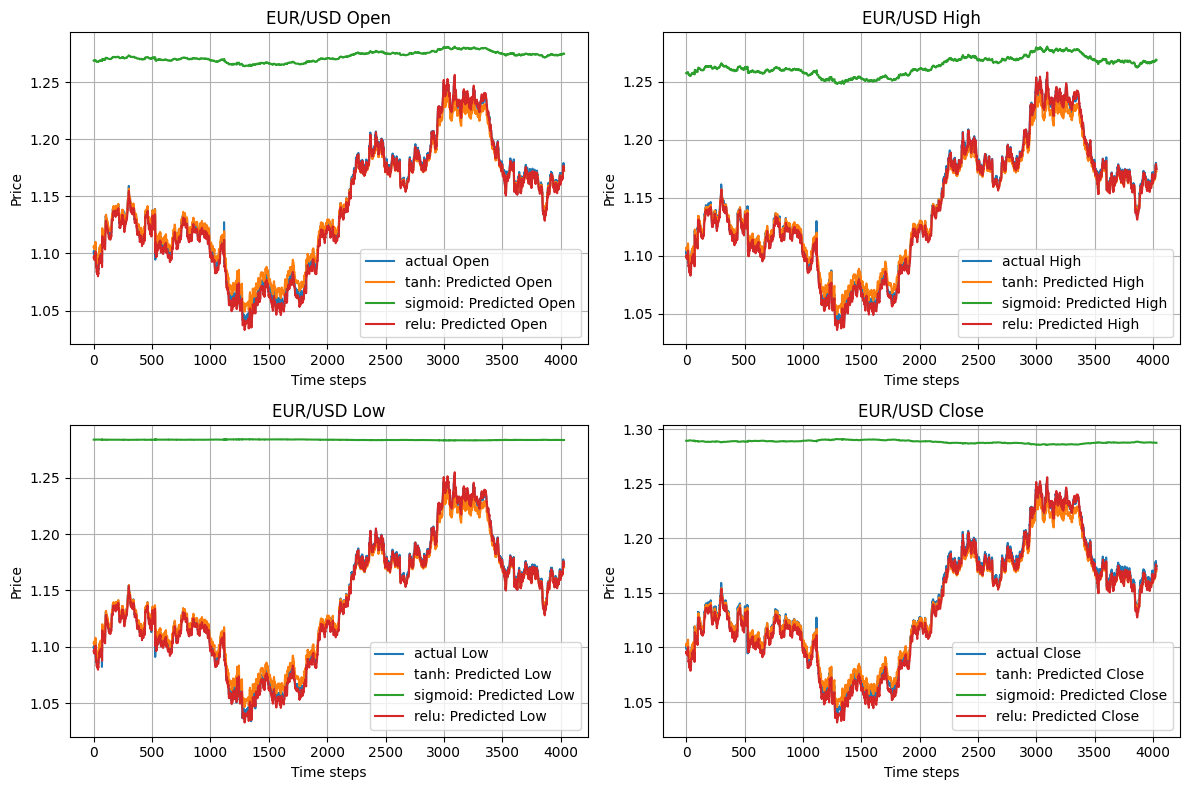

In [28]:
m.plot_grid()

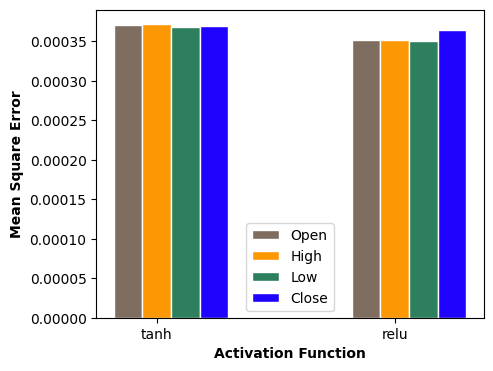

In [29]:
m.plot_error(dictionary, n=2)

# Models comparison

In [30]:
path = f'{data_path}/OHLC_LSTM_tanh.csv'
candle_all = readDt2(path)

candOpen  = candle_all['Open']
candHigh  = candle_all['High']
candLow   = candle_all['Low']
candClose = candle_all['Close']

In [31]:
path = f'{data_path}/univariate_LSTM_tanh.csv'
candle_multi_lstm = readDt2(path)

indvOpen   = candle_multi_lstm['Open']
indvHigh   = candle_multi_lstm['High']
indvLow    = candle_multi_lstm['Low']
indvClose  = candle_multi_lstm['Close']

In [32]:
path = f'{data_path}/Ground_truth.csv'
ground_truth = readDt2(path)

actualOpen   = ground_truth['Open']
actualHigh   = ground_truth['High']
actualLow    = ground_truth['Low']
actualClose  = ground_truth['Close']

In [34]:
path = f'{data_path}/FLF_tanh.csv'
FLF_candle = readDt2(path)

FLFOpen = FLF_candle['Open']
FLFHigh = FLF_candle['High']
FLFLow = FLF_candle['Low']
FLFClose = FLF_candle['Close']

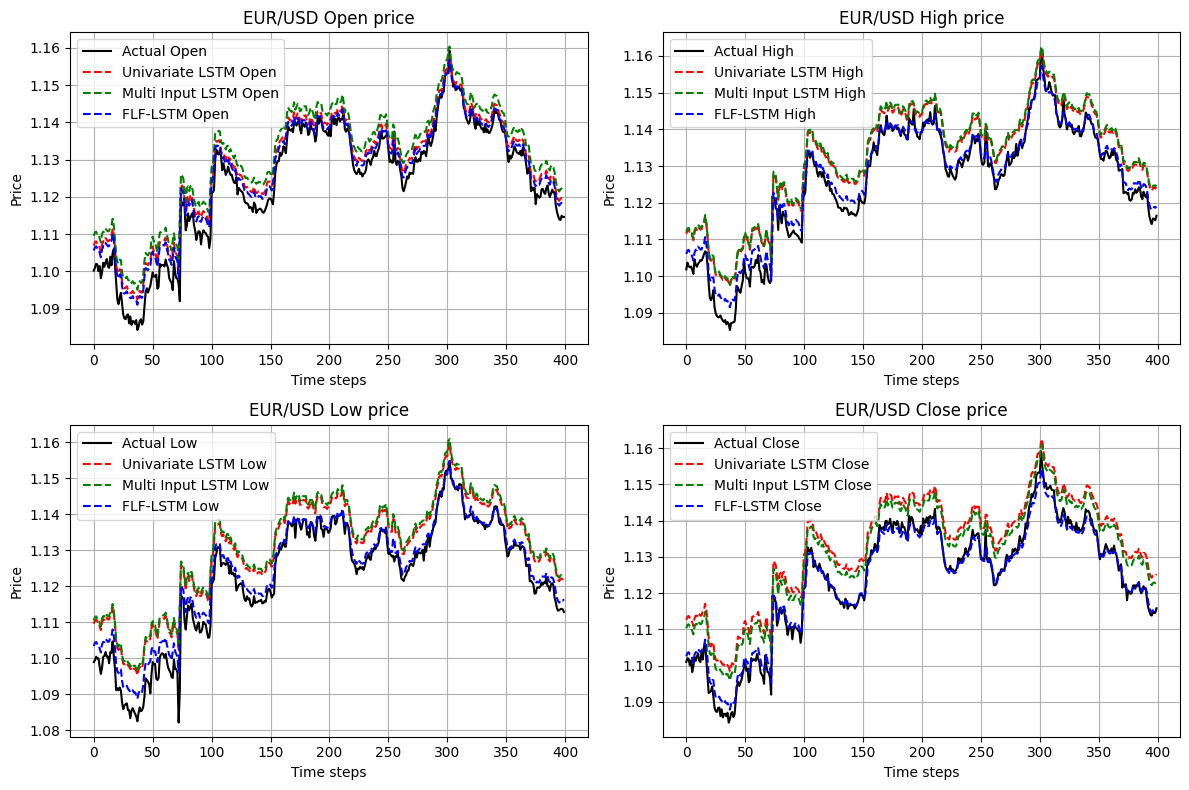

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot Open
axs[0, 0].plot(range(amount_candles), actualOpen[0:amount_candles], 'k-', label='Actual Open')
axs[0, 0].plot(range(amount_candles), indvOpen[0:amount_candles], 'r--', label='Univariate LSTM Open')
axs[0, 0].plot(range(amount_candles), candOpen[0:amount_candles], 'g--', label='OHLC LSTM Open')
axs[0, 0].plot(range(amount_candles), FLFOpen[0:amount_candles], 'b--', label='FLF-LSTM Open')
axs[0, 0].set_xlabel('Time steps')
axs[0, 0].set_ylabel('Price')
axs[0, 0].set_title('EUR/USD Open price')
axs[0, 0].grid(True)
axs[0, 0].legend(loc='upper left')

# Plot High
axs[0, 1].plot(range(amount_candles), actualHigh[0:amount_candles], 'k-', label='Actual High')
axs[0, 1].plot(range(amount_candles), indvHigh[0:amount_candles], 'r--', label='Univariate LSTM High')
axs[0, 1].plot(range(amount_candles), candHigh[0:amount_candles], 'g--', label='OHLC LSTM High')
axs[0, 1].plot(range(amount_candles), FLFHigh[0:amount_candles], 'b--', label='FLF-LSTM High')
axs[0, 1].set_xlabel('Time steps')
axs[0, 1].set_ylabel('Price')
axs[0, 1].set_title('EUR/USD High price')
axs[0, 1].grid(True)
axs[0, 1].legend(loc='upper left')

# Plot Low
axs[1, 0].plot(range(amount_candles), actualLow[0:amount_candles], 'k-', label='Actual Low')
axs[1, 0].plot(range(amount_candles), indvLow[0:amount_candles], 'r--', label='Univariate LSTM Low')
axs[1, 0].plot(range(amount_candles), candLow[0:amount_candles], 'g--', label='OHLC LSTM Low')
axs[1, 0].plot(range(amount_candles), FLFLow[0:amount_candles], 'b--', label='FLF-LSTM Low')
axs[1, 0].set_xlabel('Time steps')
axs[1, 0].set_ylabel('Price')
axs[1, 0].set_title('EUR/USD Low price')
axs[1, 0].grid(True)
axs[1, 0].legend(loc='upper left')

# Plot Close
axs[1, 1].plot(range(amount_candles), actualClose[0:amount_candles], 'k-', label='Actual Close')
axs[1, 1].plot(range(amount_candles), indvClose[0:amount_candles], 'r--', label='Univariate LSTM Close')
axs[1, 1].plot(range(amount_candles), candClose[0:amount_candles], 'g--', label='OHLC LSTM Close')
axs[1, 1].plot(range(amount_candles), FLFClose[0:amount_candles], 'b--', label='FLF-LSTM Close')
axs[1, 1].set_xlabel('Time steps')
axs[1, 1].set_ylabel('Price')
axs[1, 1].set_title('EUR/USD Close price')
axs[1, 1].grid(True)
axs[1, 1].legend(loc='upper left')

plt.tight_layout()
plt.show()